# Assess Distance Metrics

Can we predict which molecules would be most likely to have large errors? We are going to focus on the atomic contribution model, as it is the one that we find to have the best performance

In [1]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression, LinearRegression
from matplotlib import pyplot as plt
from multiprocessing import Pool
from util import has_stereoisomers
from scipy.stats import sem
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import json
import os

RDKit WARNING: [16:41:13] Enabling RDKit 2019.09.3 jupyter extensions


## Load in the Results
We computed the error for different molecules in the hold-out sets and distance metrics based on their models

In [2]:
data = dict((x, pd.read_csv(os.path.join('test-sets-with-dists', f'{x}.csv'))) for x in ['molecular-fingerprint', 'atomic-contribution'])

In [3]:
subset = data['atomic-contribution']

## Plot Different Metrics
Get an idea for how well they work

### Model Uncertainty
Based on a bootstrap ensemble

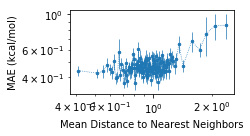

In [4]:
fig, ax = plt.subplots(figsize=(3.5, 2))

dist_col = f'model_variance'
subset[dist_col] = np.log(subset[dist_col])
dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['sol_acn_error'].abs()), sem(s['sol_acn_error'].abs())) 
                                       for s in np.array_split(subset.sort_values(dist_col), 128)])

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, marker='o', markersize=2.5, linestyle=':', lw=0.7)
ax.set_xscale('log', basex=10)
ax.set_yscale('log')
ax.set_xlabel('Mean Distance to Nearest Neighbors')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-distance.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-distance.eps'))

### Tanimoto Similarity
Assess outliers for the molecular fingerprint

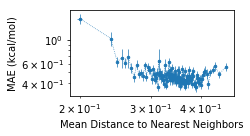

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 2))

n=64
dist_col = f'tan_sim_{n}'
dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['sol_acn_error'].abs()), sem(s['sol_acn_error'].abs())) 
                                       for s in np.array_split(subset.sort_values(dist_col), 128)])

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, label=f'k={n}', marker='o', 
            markersize=2.5, linestyle=':', lw=0.7)
ax.set_xscale('log', basex=10)
ax.set_yscale('log')
ax.set_xlabel('Mean Distance to Nearest Neighbors')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-distance.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-distance.eps'))

*Finding*: We do at least see a positive correlation

### Molecular Fingerprint
Assess outliers for the molecular fingerprint

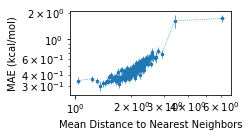

In [6]:
fig, ax = plt.subplots(figsize=(3.5, 2))

n=4
dist_col = f'train_dist_mol_{n}'
dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['sol_acn_error'].abs()), sem(s['sol_acn_error'].abs())) 
                                       for s in np.array_split(subset.sort_values(dist_col), 128)])

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, label=f'k={n}', marker='o', 
            markersize=2.5, linestyle=':', lw=0.7)
ax.set_xscale('log', basex=10)
ax.set_yscale('log')
ax.set_xlabel('Mean Distance to Nearest Neighbors')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-distance.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-distance.eps'))

### Atomic-Level Features
We define the distance between molecules as the average distance of each atomic representation

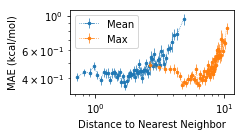

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2))

n=64
for t in ['mean', 'max']:
    dist_col = f'train_dist_atom_{t}_{n}'
    dist_mean, dist_sem, err_mean, err_sem = zip(*[(np.mean(s[dist_col]), sem(s[dist_col]), np.mean(s['sol_acn_error'].abs()), sem(s['sol_acn_error'].abs())) 
                                           for s in np.array_split(subset.sort_values(dist_col), 64)[2:]])

    ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem, label=t.capitalize(), marker='o', 
                markersize=2.5, linestyle=':', lw=0.7)
ax.legend()
ax.set_xscale('log', basex=10)
ax.set_yscale('log')
ax.set_xlabel('Distance to Nearest Neighbor')
ax.set_ylabel('MAE (kcal/mol)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-distance_atomic.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-distance_atomic.eps'))

*Finding*: Monotonic increase for the mean slope

Determine a "cutoff for the total error?

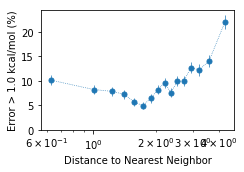

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

n=64
error_cutoff = 1 # kcal/mol
dist_col = f'train_dist_atom_mean_{n}'
dist_mean, dist_sem, err_mean, err_sem = zip(
    *[(np.mean(s[dist_col]), sem(s[dist_col]), 
       np.mean(s['sol_acn_error'].abs() > error_cutoff) * 100, 
       sem(s['sol_acn_error'].abs() > error_cutoff) * 100) 
      for s in np.array_split(subset.sort_values(dist_col), 16)]
)

ax.errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem,
            label=f'k={n}', marker='o', 
            markersize=5, linestyle=':', lw=0.7)
ax.set_xscale('log', basex=10)
ax.set_xlabel('Distance to Nearest Neighbor')
ax.set_ylim(0)
ax.set_ylabel(f'Error >{error_cutoff: 0.1f} kcal/mol (%)')
fig.tight_layout()
fig.savefig(os.path.join('figures', 'error-vs-liklihood-bad.png'), dpi=320)
fig.savefig(os.path.join('figures', 'error-vs-liklihood-bad.eps'))

*Finding*: We can establish cutoff for "I'm expecting this error to be large"

## Plot all Metrics
Normalize the distances and see which performs better

/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureW

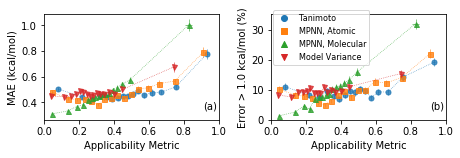

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.25))

# Plot configuration
n = 64
error_cutoff = 1 # kcal/mol
n_bins = 16

# Plot each metric
legnd_data = []
labels = ['Tanimoto', 'MPNN, Atomic', 'MPNN, Molecular', 'Model Variance']
for label, col, m in zip(labels,
                     [f'tan_sim_{n}', f'train_dist_atom_mean_{n}', f'train_dist_mol_{n}', 'model_variance', 'n_heavy_atoms'],
                     ['o', 's', '^', 'v', 'p']):
    # Order the molecules by ascending "badness"
    if col.startswith('tan_sim'):
        dist = 1.0 - subset[col].values
    else:
        dist = subset[col].values
    order = np.argsort(dist)
    dist = dist[order]
    error = np.abs(subset['sol_acn_error'].values[order])
    
    # Normalize the distances by percentile
    min_scale = np.percentile(dist, 1)
    max_scale = np.percentile(dist, 99)
    normed_dists = (dist - min_scale) / (max_scale - min_scale)
    with open(os.path.join('error-models', f'{col}-dist-scaling.json'), 'w') as fp:
        json.dump({'min_dist': min_scale, 'max_dist': max_scale}, fp)
    
    # Bin by distance
    dist_mean, dist_sem, err_mean, err_sem, prob_mean, prob_sem = zip(
        *[(np.mean(s[:, 0]), sem(s[:, 0]), 
           np.mean(s[:, 1]), sem(s[:, 1]),
           np.mean(s[:, 1] > error_cutoff) * 100, 
           sem(s[:, 1] > error_cutoff) * 100) 
          for s in np.array_split(np.vstack((normed_dists, error)).T, n_bins)]
    )
    axs[0].errorbar(dist_mean, err_mean, xerr=dist_sem, yerr=err_sem,
                label=label, marker=m, alpha=0.8,
                markersize=5, linestyle=':', lw=0.7)
    l = axs[1].errorbar(dist_mean, prob_mean, xerr=dist_sem, yerr=prob_sem,
                label=label, marker=m, alpha=0.8,
                markersize=5, linestyle=':', lw=0.7)
    
    # Fit an expontential to the data
    lr = LinearRegression()
    x = np.linspace(0, 1, 128)
    lr.fit(np.expand_dims(dist_mean, 1), np.log(err_mean))
    lr_fit = np.exp(lr.predict(x[:, None]))
    with open(os.path.join('error-models', f'{col}_mag.pkl'), 'wb') as fp:
        pkl.dump(lr, fp)
    #axs[0].plot(x, lr_fit, color=l[0].get_color(), alpha=0.7)
    
    
    
    # Fit a logistic regression model to data
    lr = LogisticRegression()
    lr.fit(normed_dists[:, None], error > error_cutoff)
    lr_fit = lr.predict_proba(x[:, None])[:, 1]
    with open(os.path.join('error-models', f'{col}_prob.pkl'), 'wb') as fp:
        pkl.dump(lr, fp)
    #axs[1].plot(x, lr_fit*100, color=l[0].get_color(), alpha=0.7)
    
    
    # Make the legend-ready plot
    legnd_data.append(axs[0].scatter([], [], color=l[0].get_color(), marker=m))

# Label axes and such
axs[1].legend(legnd_data, labels, loc=(0.01, 0.52), ncol=1, fontsize=8)
#axs[0].set_yscale('log')
#ax.set_xscale('log', basex=10)
axs[1].set_ylim(0)
for ax in axs:
    ax.set_xlim(0, 1)

for ax in axs:
    ax.set_xlabel('Applicability Metric')
axs[0].set_ylabel('MAE (kcal/mol)')
axs[1].set_ylabel(f'Error >{error_cutoff: 0.1f} kcal/mol (%)')

axs[0].text(0.99, 0.1, '(a)', transform=axs[0].transAxes, ha='right')
axs[1].text(0.99, 0.1, '(b)', transform=axs[1].transAxes, ha='right')

fig.tight_layout()
fig.savefig(os.path.join('figures', 'distance-metrics.png'), dpi=320)
fig.savefig(os.path.join('figures', 'distance-metrics.eps'))

*Finding*: Measuring distance with the MPNN feature set seems to be our best way of detecting which prediction are most likely to be faulty